In [1]:
import numpy as np
import scipy.io as sio
import re  # <-- FALTABA

def load_mat(path):
    return sio.loadmat(path, simplify_cells=True)

def find_movement_rep(mat_struct, movement, rep=1, data_field="DAQ_DATA"):
    if not isinstance(movement, str) or len(movement.strip()) == 0:
        raise ValueError("movement debe ser un string no vacío, ej: 'hook', 'handopen'...")

    mv = movement.strip().lower()
    rep_str = str(rep)

    keys = [k for k in mat_struct.keys() if not k.startswith("__")]
    if not keys:
        raise KeyError("El .mat no contiene claves útiles (solo metadatos).")

    def norm(s):
        return re.sub(r"[\s\-]+", "", s.lower())

    mv_norm = norm(mv)

    mv_cand = [k for k in keys if mv_norm in norm(k)]
    if not mv_cand:
        msg = f"No encuentro ninguna clave relacionada con '{movement}'. "
        msg += f"Keys disponibles (primeras 50): {keys[:50]}"
        raise KeyError(msg)

    def rep_score(k):
        kl = norm(k)
        score = 0
        if re.search(rf"_{rep_str}\b", k):         # exact "_1"
            score += 5
        if kl.endswith(rep_str):                    # termina en 1
            score += 4
        if re.search(rf"rep{rep_str}\b", kl):       # contiene "rep1"
            score += 4
        if re.search(rf"\b{rep_str}\b", k):         # aparece como token
            score += 2
        return score

    mv_cand_sorted = sorted(mv_cand, key=lambda k: rep_score(k), reverse=True)

    for k in mv_cand_sorted:
        obj = mat_struct[k]

        if isinstance(obj, np.ndarray) and obj.ndim == 2:
            return obj, k

        if isinstance(obj, dict):
            if data_field in obj:
                X = np.array(obj[data_field])
                if X.ndim == 2:
                    return X, f"{k}.{data_field}"

            for kk in obj.keys():
                kkl = kk.lower()
                if ("daq" in kkl and "data" in kkl) or (data_field.lower() in kkl):
                    X = np.array(obj[kk])
                    if isinstance(X, np.ndarray) and X.ndim == 2:
                        return X, f"{k}.{kk}"

            for kk in obj.keys():
                X = np.array(obj[kk])
                if isinstance(X, np.ndarray) and X.ndim == 2:
                    return X, f"{k}.{kk}"

    raise TypeError(
        f"Encontré claves para '{movement}' (ej: {mv_cand_sorted[:5]}), "
        f"pero no pude extraer una matriz EMG 2D (samples x channels)."
    )

# --- USO ---
path_post = r"C:/Users/34648/Desktop/Clases/4_GITT/TFG/OPENICPSR/TR2_preTMR_32chanEMG.mat"
mat_post = load_mat(path_post)

X, key = find_movement_rep(mat_post, movement="handopen", rep=2)
fs = 1000  # Hz

print("Campo encontrado:", key)
print("Shape:", X.shape, "(samples x channels)")


Campo encontrado: HandOpen_2.DAQ_DATA
Shape: (2001, 32) (samples x channels)


In [26]:
from scipy.signal import butter, filtfilt, iirnotch

def bandpass(x, fs, lo=20, hi=450, order=4):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch(x, fs, f0=50, Q=30):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def rms_envelope(x, fs, win_ms=100):
    win = int(round(win_ms * fs / 1000))
    win = max(win, 1)
    # RMS por convolución: mean(x^2) en ventana
    x2 = x**2
    kernel = np.ones((win, 1)) / win
    mean_x2 = np.apply_along_axis(lambda v: np.convolve(v, kernel[:,0], mode="same"), 0, x2)
    return np.sqrt(mean_x2)

# --- pipeline ---
Xf = bandpass(X, fs)
Xf = notch(Xf, fs, f0=50)   # cambia a 60 si procede
env = rms_envelope(Xf, fs, win_ms=100)  # samples x channels


In [33]:
def detect_onset_offset(env, fs, k=2.0, min_dur_ms=150):
    """
    env: (samples x channels) RMS
    devuelve onset/offset en muestras y segundos usando umbral sobre RMS media.
    """
    g = env.mean(axis=1)  # RMS global
    # baseline: primer 20% del ensayo (ajusta si tu rep está recortada distinto)
    n0 = int(0.2 * len(g))
    base = g[:n0]
    thr = base.mean() + k * base.std()

    above = g > thr
    # limpia activaciones cortas
    min_len = int(min_dur_ms * fs / 1000)
    # encuentra segmentos
    idx = np.where(above)[0]
    if len(idx) == 0:
        return None, None, thr, g

    # agrupa índices contiguos
    splits = np.where(np.diff(idx) > 1)[0] + 1
    groups = np.split(idx, splits)
    # filtra por duración
    groups = [gr for gr in groups if len(gr) >= min_len]
    if not groups:
        return None, None, thr, g

    # el segmento principal = el más largo
    gr = max(groups, key=len)
    onset, offset = gr[0], gr[-1]
    return onset, offset, thr, g

on, off, thr, g = detect_onset_offset(env, fs, k=1.5)

print("thr:", thr)
print("on/off (samples):", on, off)
print("on/off (sec):", on/fs, off/fs)


thr: 0.5736587840531833
on/off (samples): None None


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

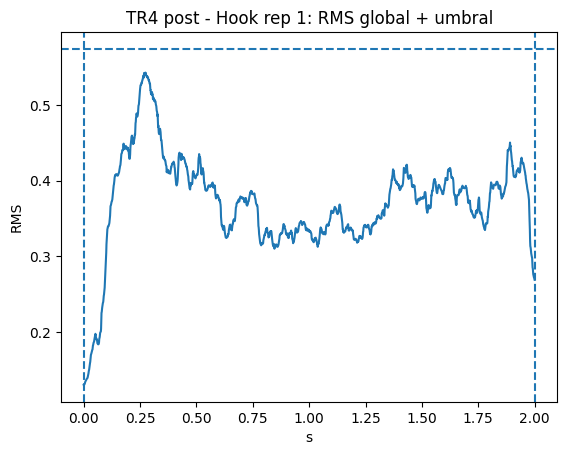

In [35]:
import matplotlib.pyplot as plt

t = np.arange(len(g)) / fs
plt.figure()
plt.plot(t, g)
plt.axhline(thr, linestyle="--")
if on is not None:
    plt.axvline(on/fs, linestyle="--")
    plt.axvline(off/fs, linestyle="--")
plt.title("TR4 post - Hook rep 1: RMS global + umbral")
plt.xlabel("s")
plt.ylabel("RMS")
plt.show()


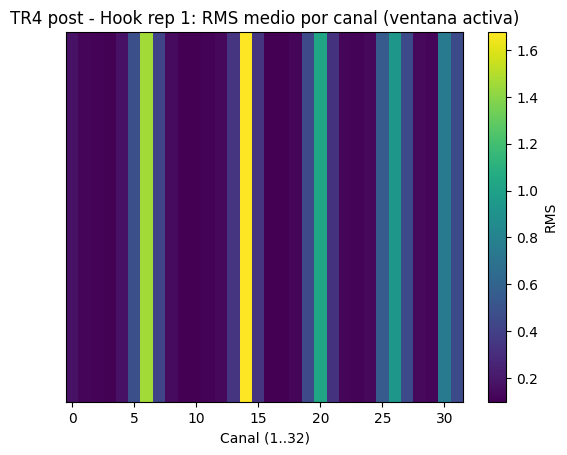

In [34]:
if on is None:
    on, off = 0, len(env)-1

# métrica por canal en ventana activa: RMS medio
feat = env[on:off].mean(axis=0)  # (32,)

plt.figure()
plt.imshow(feat.reshape(1, -1), aspect="auto")
plt.title("TR4 post - Hook rep 1: RMS medio por canal (ventana activa)")
plt.xlabel("Canal (1..32)")
plt.yticks([])
plt.colorbar(label="RMS")
plt.show()
